# Visualization: Conformational Selection Results

In [1]:
import pandas as pd
import joblib 

In [2]:
# Load some auxiliary functions
%run 1_Helper_functions.ipynb

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Load the results file

In [3]:
# Load the results file
path_to_file = './conformational_selection_30x4cv_using_k_confs.obj'

with open(path_to_file, 'rb') as f:
    conf_sel_results = joblib.load(f)

In [4]:
# Determine the k values used
k_values = [int(i.split('_')[1]) 
            for i in conf_sel_results['random'].keys()]
k_values

[1, 2, 4, 8, 16, 32, 64, 128, 136]

In [5]:
# Map new names for each VS method, for plotting
sbvs_names = {
     'ml_lr': 'LR',
     'ml_xgb': 'GBT',
     'ml_dclf': 'DClf',
     'cs_MEAN': 'csAVG',
     'cs_GEOM': 'csGEO',
     'cs_MIN': 'csMIN'
}
sbvs_methods = list(sbvs_names.values())

## Plot results

In [6]:
%load_ext rpy2.ipython

### AUC-ROC

In [7]:
metric_name = 'roc_auc'
dict_res = {test_name: 
            get_group_stats(
               df, 
               metric_name = metric_name, 
               indexes_values = k_values)\
            .replace(sbvs_names)
            for test_name, df in conf_sel_results.items()
           }

df_roc = pd.concat(dict_res.values(), 
                   keys = dict_res.keys())\
                   .reset_index()\
                   .drop(['level_1'], axis=1)\
                   .rename(columns={'level_0': 'selection'})

# Just if needed
df_roc.method = df_roc.method.replace({'cs_GEO': 'csGEO'})
# We will ommit 128 for visualization purposes
idxs = df_roc[df_roc['index'] == 128].index
df_roc = df_roc.drop(idxs)
df_roc

,selection,index,method,mean,std
0,random,1,LR,0.616193,0.048750
1,random,2,LR,0.630085,0.038155
2,random,4,LR,0.642319,0.041459
3,random,8,LR,0.664070,0.038083
4,random,16,LR,0.704455,0.043151
...,...,...,...,...,...
318,bigPkVolume,8,csMIN,0.582334,0.021502
319,bigPkVolume,16,csMIN,0.602121,0.021594
320,bigPkVolume,32,csMIN,0.629190,0.021361
321,bigPkVolume,64,csMIN,0.624163,0.021630


#### Initialize some variables

In [8]:
%%R -i k_values -i sbvs_methods
source('../../R_scripts/plot_violinBox.R')

# Initialize some variables
protein_name <- 'fxa'
x_ticks <- c(1, 2, 4, 8, 16, 32, 64, 136)
sbvs_methods <- unlist(sbvs_methods)
select_criteria <- c('RFExgb', 'singConfAUC', 
                     'singConfAUC-Worst', 
                     'random', 'bigLigMW')
cbbPalette <- hue_pal()(10)

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Co

#### Plot using `ggplot2`

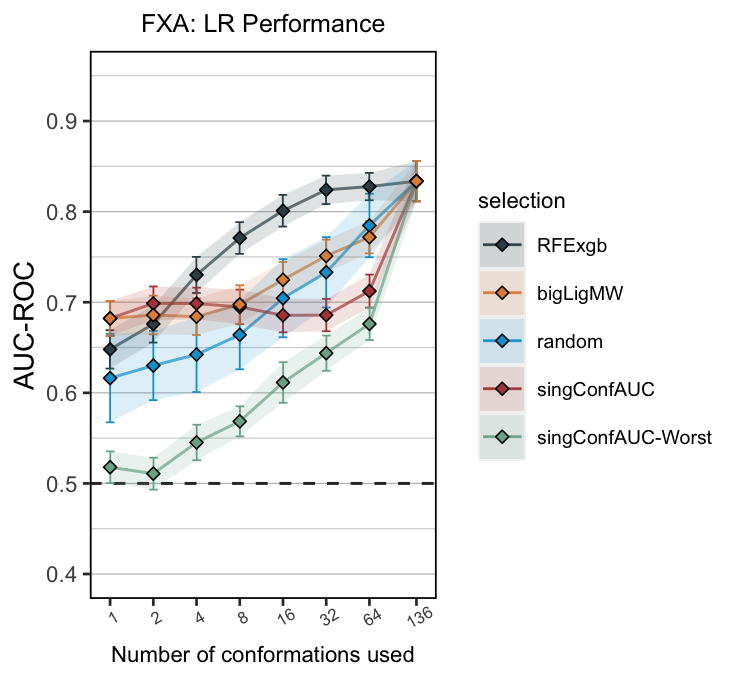

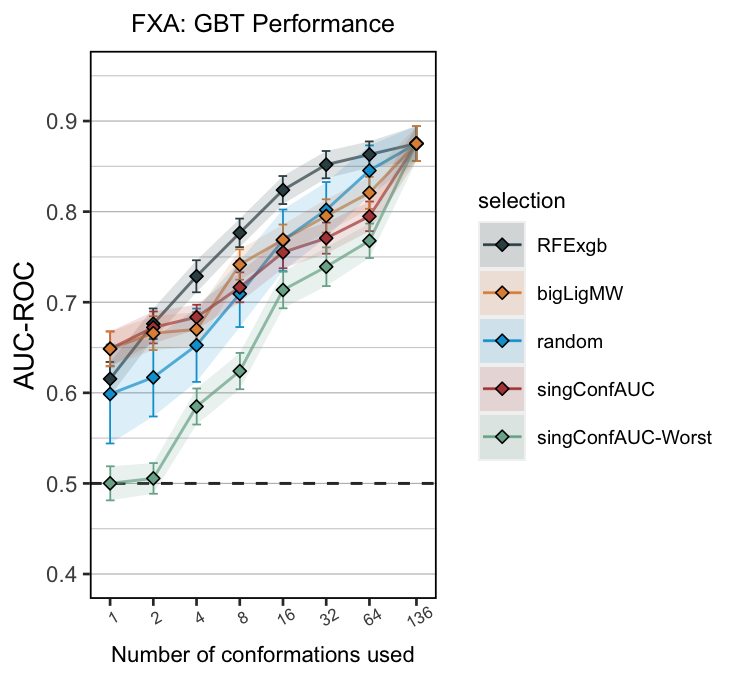

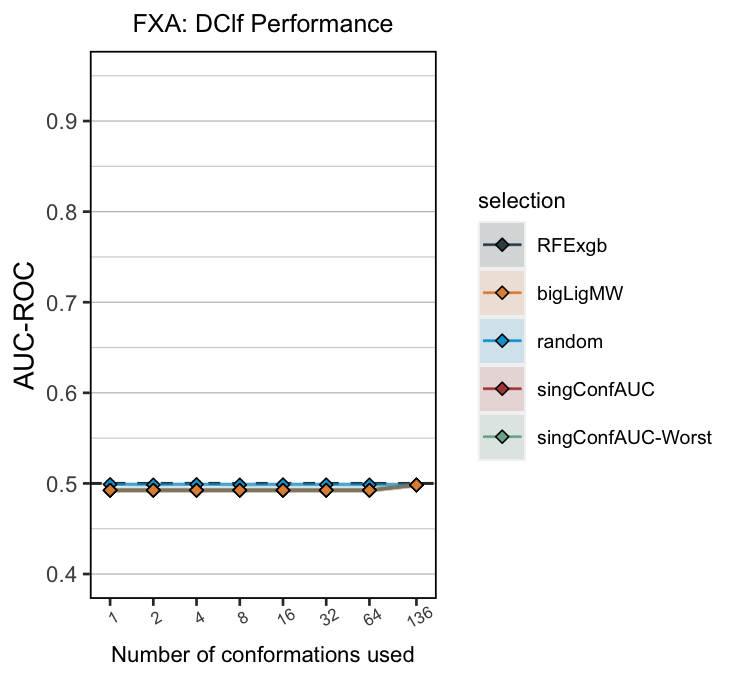

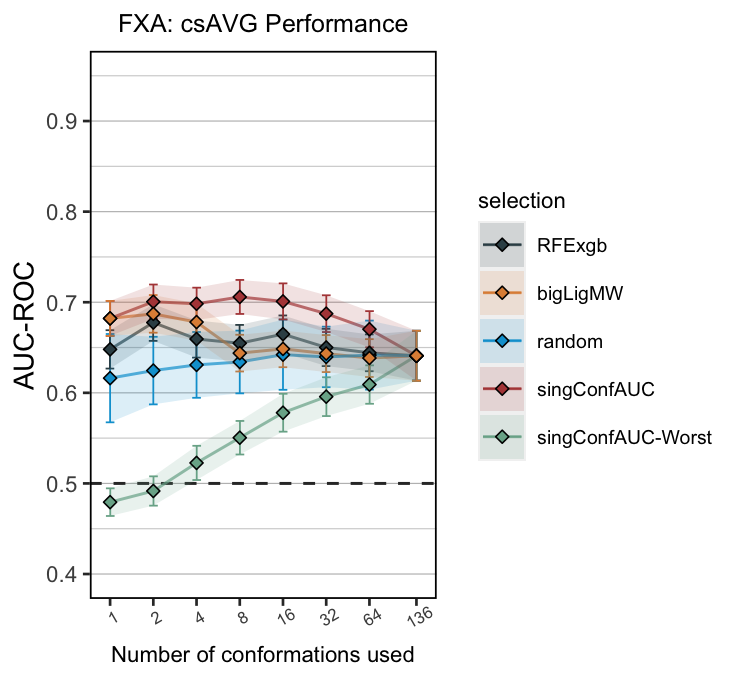

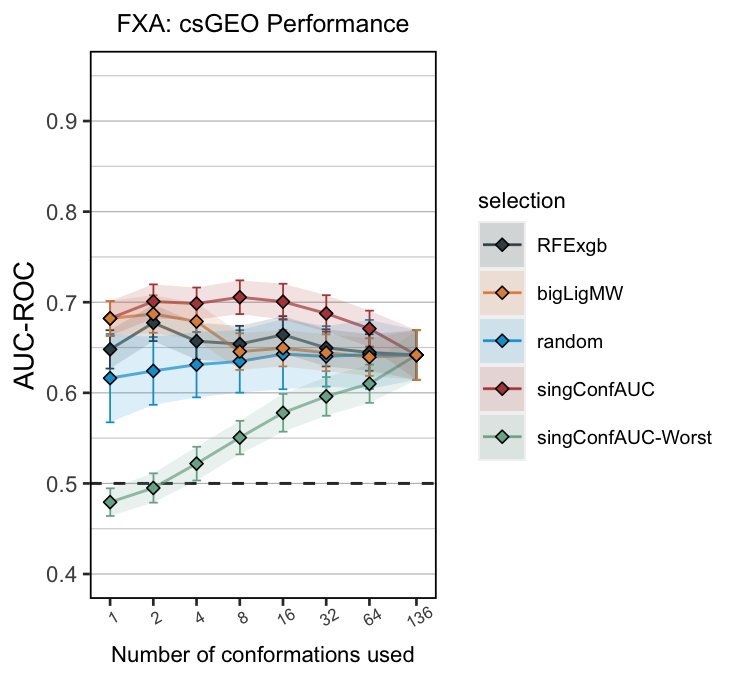

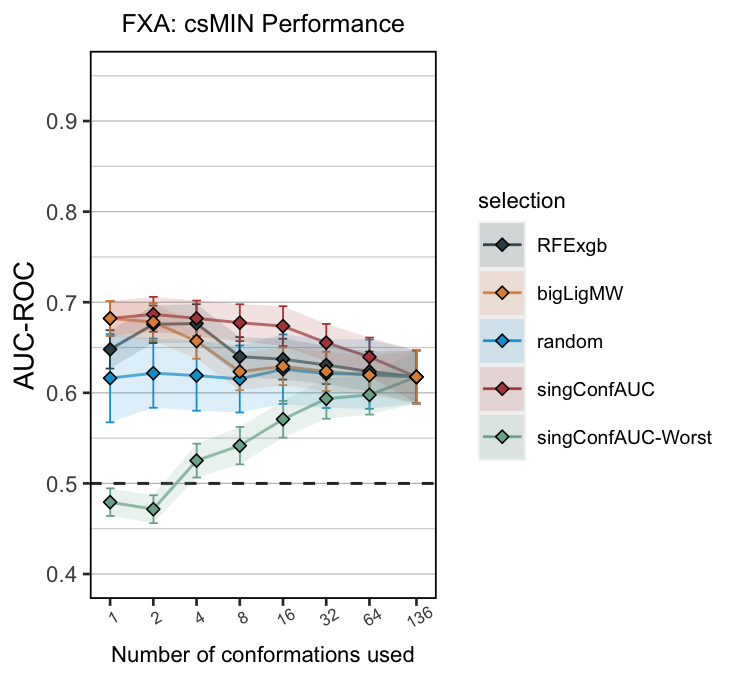

In [9]:
%%R -i df_roc -i metric_name -w 3.7 -h 3.4 --units in -r 200

source('../../R_scripts/plot_violinBox.R')
metric_name <- 'AUC-ROC' 

for(vs_method in sbvs_methods){
    df <- df_roc %>%
    filter(method == vs_method) %>%
    filter(index %in% x_ticks) %>%
    filter(selection %in% select_criteria)

p = plot_lines(df, cbbPalette=cbbPalette, 
               y_min = 0.4, 
               y_max = 0.95, 
               error_dodge = 0.01, error_size = 0.3, error_width=1,
               point_size = 1.5, line_size  = 0.5, shape=23,
               add_ribbon = T, ribbon_alpha = 0.15, 
               include_color_scale = F,
               base_h_line = 0.5, switch_x = FALSE,  
               ticks.text.angle = 30, ticks.text.size = 6,  
               title.size = 9,
               legend.position = 'right',
               y_label = metric_name,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans = 'log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0(toupper(protein_name), ': ', vs_method, ' Performance'))
print(p)
}

### Normalized Enrichment Factor

In [10]:
metric_name = 'nef_12_Ra'
dict_res = {test_name: 
            get_group_stats(
               df, 
               metric_name = metric_name, 
               indexes_values = k_values)\
            .replace(sbvs_names)
            for test_name, df in conf_sel_results.items()
           }

df_nef = pd.concat(dict_res.values(), 
                   keys = dict_res.keys())\
                   .reset_index()\
                   .drop(['level_1'], axis=1)\
                   .rename(columns={'level_0': 'selection'})
# Just if needed
df_nef.method = df_nef.method.replace({'cs_GEO': 'csGEO'})
# We will ommit 128 for visualization purposes
idxs = df_nef[df_nef['index'] == 128].index
df_nef = df_nef.drop(idxs)

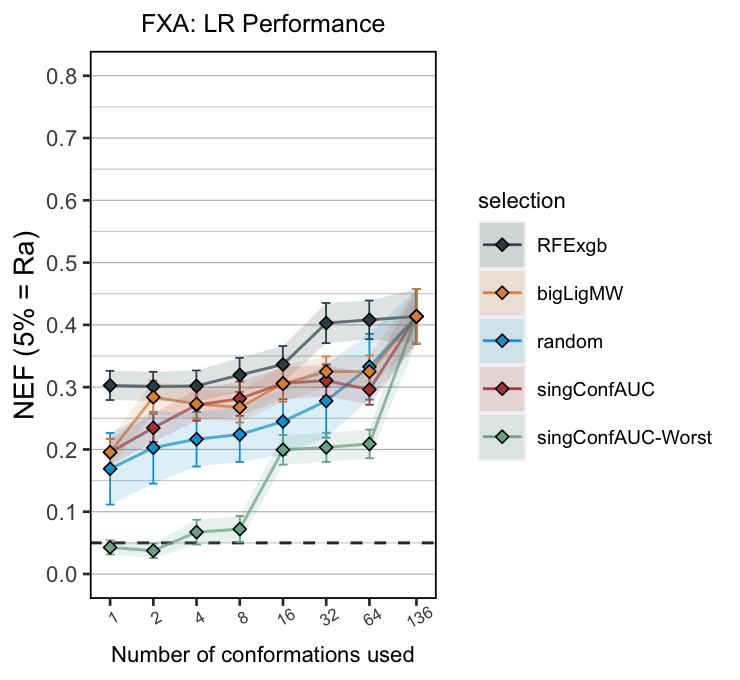

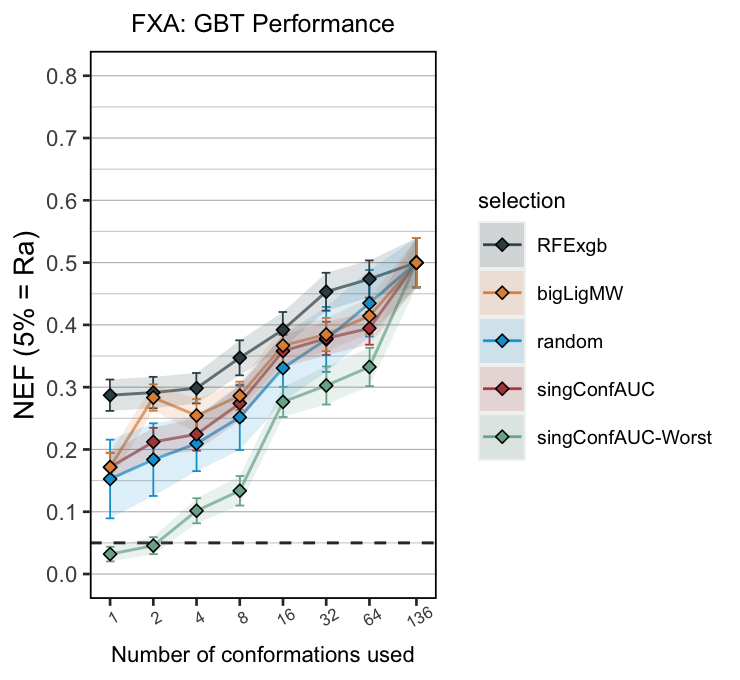

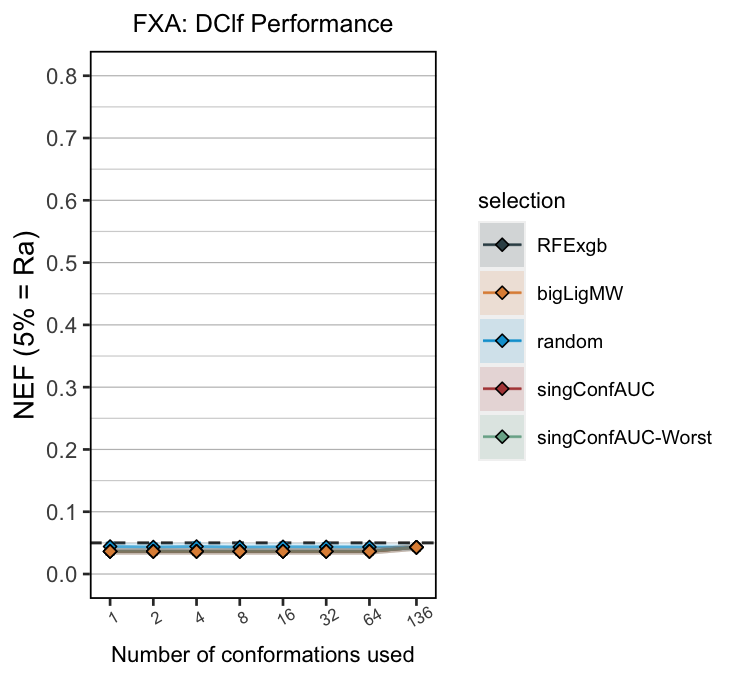

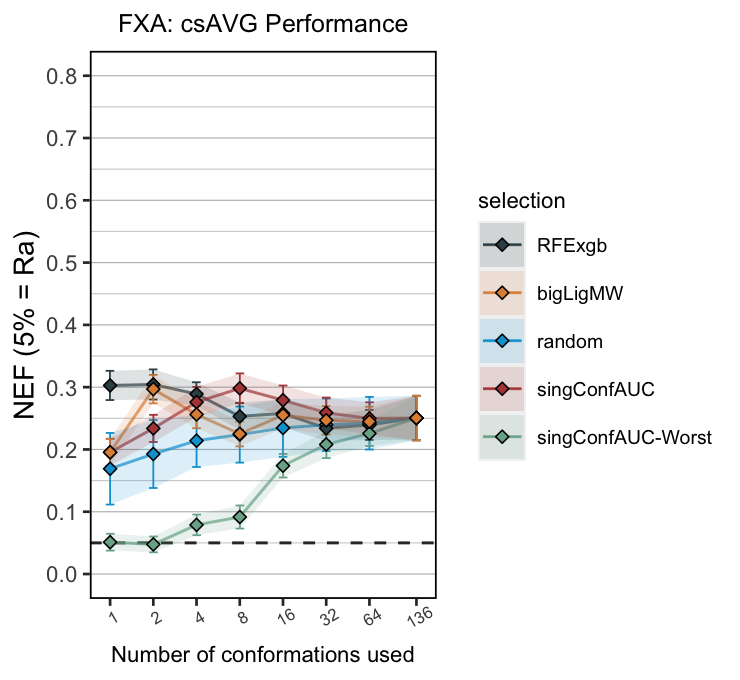

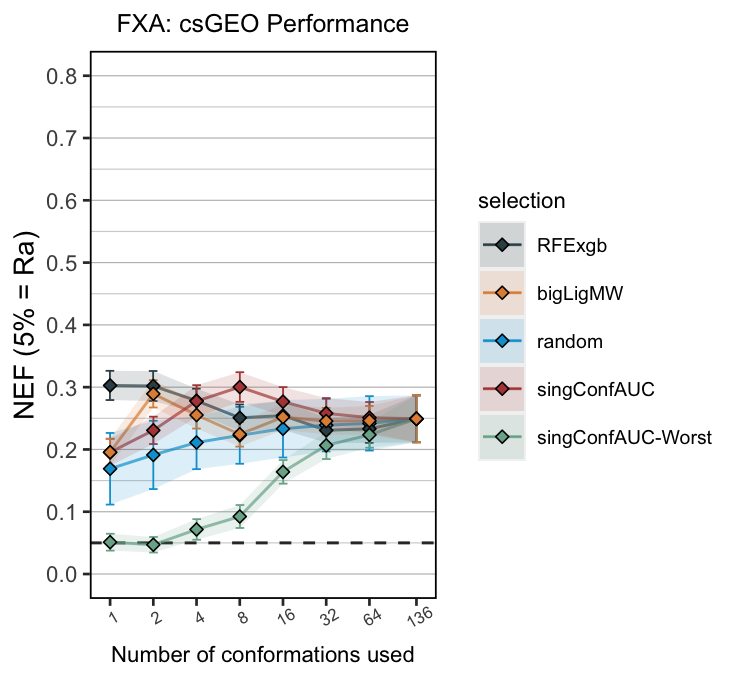

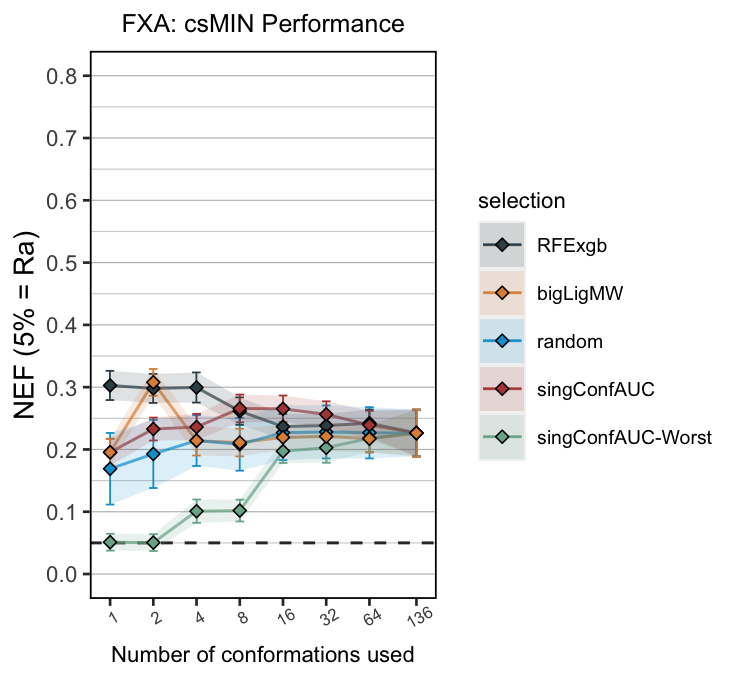

In [11]:
%%R -i df_nef -i metric_name -w 3.7 -h 3.4 --units in -r 200

source('../../R_scripts/plot_violinBox.R')
metric_name <- 'NEF (5% = Ra)'
R_a <- 0.05

for(vs_method in sbvs_methods){
    df <- df_nef %>%
    filter(method == vs_method) %>%
    filter(index %in% x_ticks) %>%
    filter(selection %in% select_criteria)

p = plot_lines(df, cbbPalette=cbbPalette, 
               y_min = 0.0, 
               y_max = 0.8, 
               error_dodge = 0.01, error_size = 0.3, error_width=1,
               point_size = 1.5, line_size  = 0.5, shape=23,
               add_ribbon = T, ribbon_alpha = 0.15, 
               include_color_scale = F,
               base_h_line = R_a, switch_x = FALSE,  
               ticks.text.angle = 30, ticks.text.size = 6,  
               title.size = 9,
               legend.position = 'right',
               y_label = metric_name,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans = 'log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0(toupper(protein_name), ': ', vs_method, ' Performance'))
print(p)
}